data source --> https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set 


Real estate valuation data set. (2018). UCI Machine Learning Repository. https://doi.org/10.24432/C5J30W. 

In [58]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as sts

# Load the data from the CSV file
real_estate = pd.read_csv('Real estate.csv', encoding = "utf-8")
print('This is the Real Estate data')
real_estate = real_estate[real_estate['Y house price of unit area'] <= 100]
real_estate.head()

This is the Real Estate data


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [59]:
# Set the default credible interval used by arviz
az.rcParams["stats.hdi_prob"] = 0.89

# Display information about each of the variables (columns) in the data set
az.summary(real_estate.to_dict(orient="list"), kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
No,207.346,119.760,1.000,369.000
X1 transaction date,2013.149,0.282,2012.667,2013.500
X2 house age,17.729,11.401,0.000,34.500
X3 distance to the nearest MRT station,1085.899,1262.975,23.383,2469.645
X4 number of convenience stores,4.102,2.945,0.000,8.000
X5 latitude,24.969,0.012,24.948,24.986
X6 longitude,121.533,0.015,121.510,121.552
Y house price of unit area,37.788,13.046,17.400,58.100


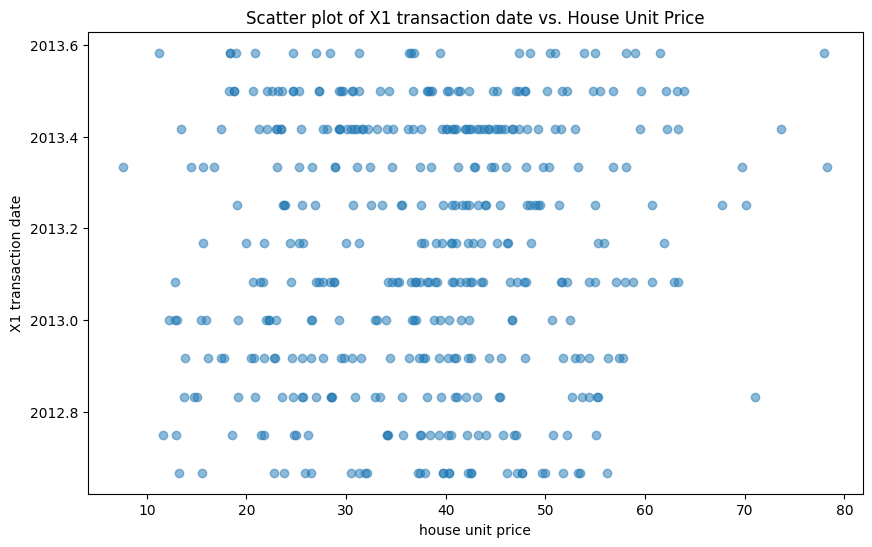

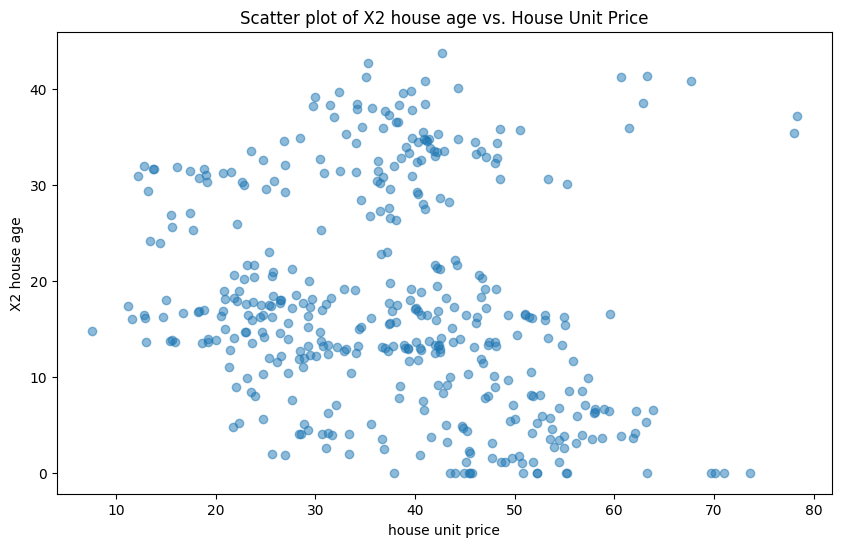

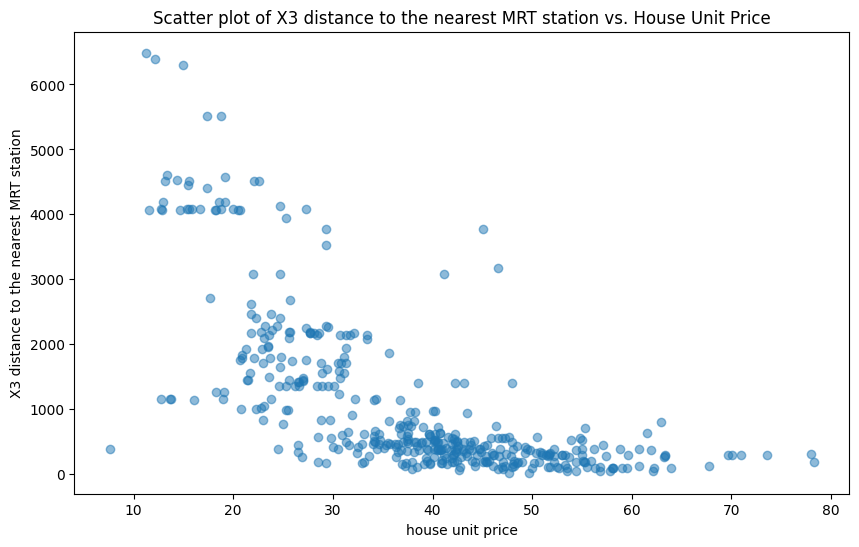

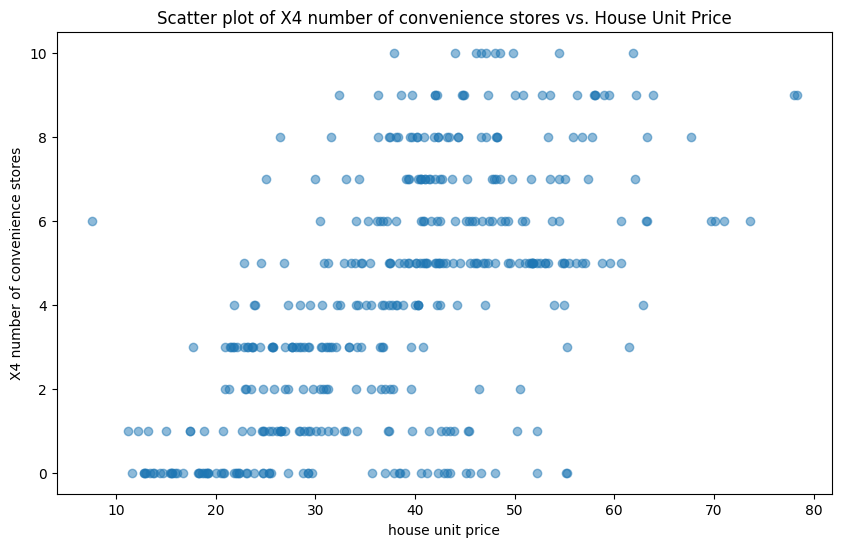

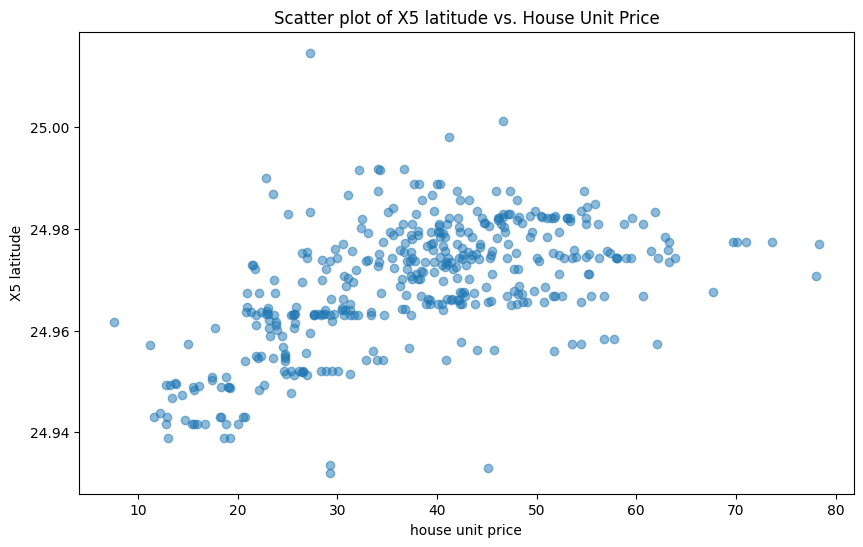

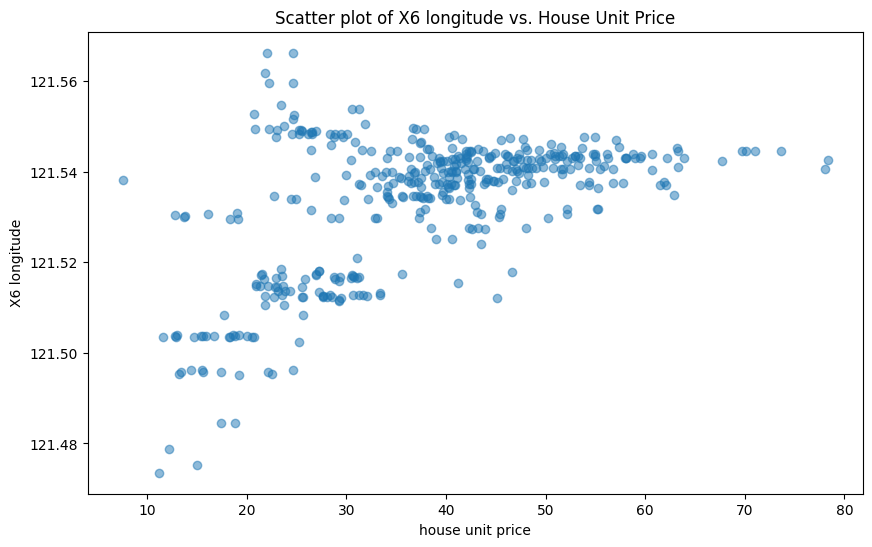

In [60]:
# List of columns to plot against 'house price'
except_col = {'Y house price of unit area', 'No'}
columns_to_plot = [col for col in real_estate.columns if col not in except_col]

for col in columns_to_plot:
    plt.figure(figsize=(10,6))  # Adjust figure size as per your preference
    plt.scatter(real_estate['Y house price of unit area'], real_estate[col], alpha=0.5)
    plt.title(f'Scatter plot of {col} vs. House Unit Price')
    plt.ylabel(col)
    plt.xlabel('house unit price')
    plt.show()

In [81]:

# columns of interest
mrt_distance = real_estate['X2 house age'] 
house_age = real_estate['X2 house age']
unit_price = real_estate['Y house price of unit area']

In [82]:
with pm.Model() as model:
    
    # YOUR PRIORS GO HERE
    c0 = pm.TruncatedNormal('c0', mu= 4, sigma = 5, lower = 0, upper = 100) # this is the mean of the mean!
    c1 = pm.TruncatedNormal('c1', mu=1, sigma = 5, lower = 0, upper = 100)
    sigma = pm.TruncatedNormal('sigma', mu = 5 , sigma = 3, lower = 0, upper = 100)
    
    # Data
    x = pm.MutableData('x', unit_price)
    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x)
    # Likelihood
    pm.Normal('y', mu=mu, sigma=sigma, observed=mrt_distance)


Sampling: [c0, c1, sigma, y]


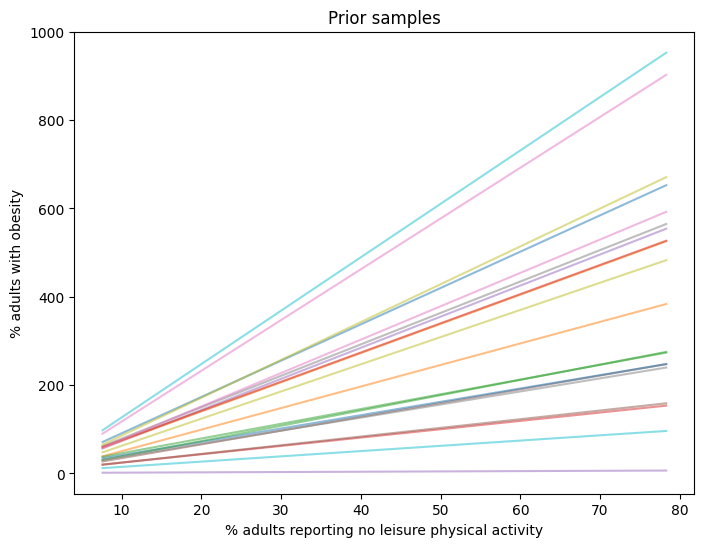

In [83]:
with model:
    inference = pm.sample_prior_predictive(20)

plt.figure(figsize=(8, 6))
plt.title('Prior samples')
plt.xlabel('% adults reporting no leisure physical activity')
plt.ylabel('% adults with obesity')
plot_x = np.array([unit_price.min(), unit_price.max()])
plot_y = (
    inference.prior.c0.values +
    plot_x.reshape(-1, 1) * inference.prior.c1.values)
plt.plot(plot_x, plot_y, alpha=0.5)
plt.show()

# QUESTION: this plot only takes into account c0 and c1

In [84]:
with model:
    inference = pm.sample()

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/tensor/elemwise.py:781: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/tensor/elemwise.py:781: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/tensor/elemwise.py:781: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/tensor/rewriting/elemwise.py:1019: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/pytensor/tensor/elemwise.py:781: RuntimeWarning: divide 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 132 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.


In [85]:
az.summary(inference, var_names=['c0', 'c1', 'sigma'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,17.120,0.702,16.055,18.230,0.026,0.019,988.0,460.0,1.01
c1,0.012,0.011,0.000,0.025,0.000,0.000,905.0,550.0,1.00
sigma,11.364,0.391,10.770,12.012,0.008,0.006,2131.0,2061.0,1.00


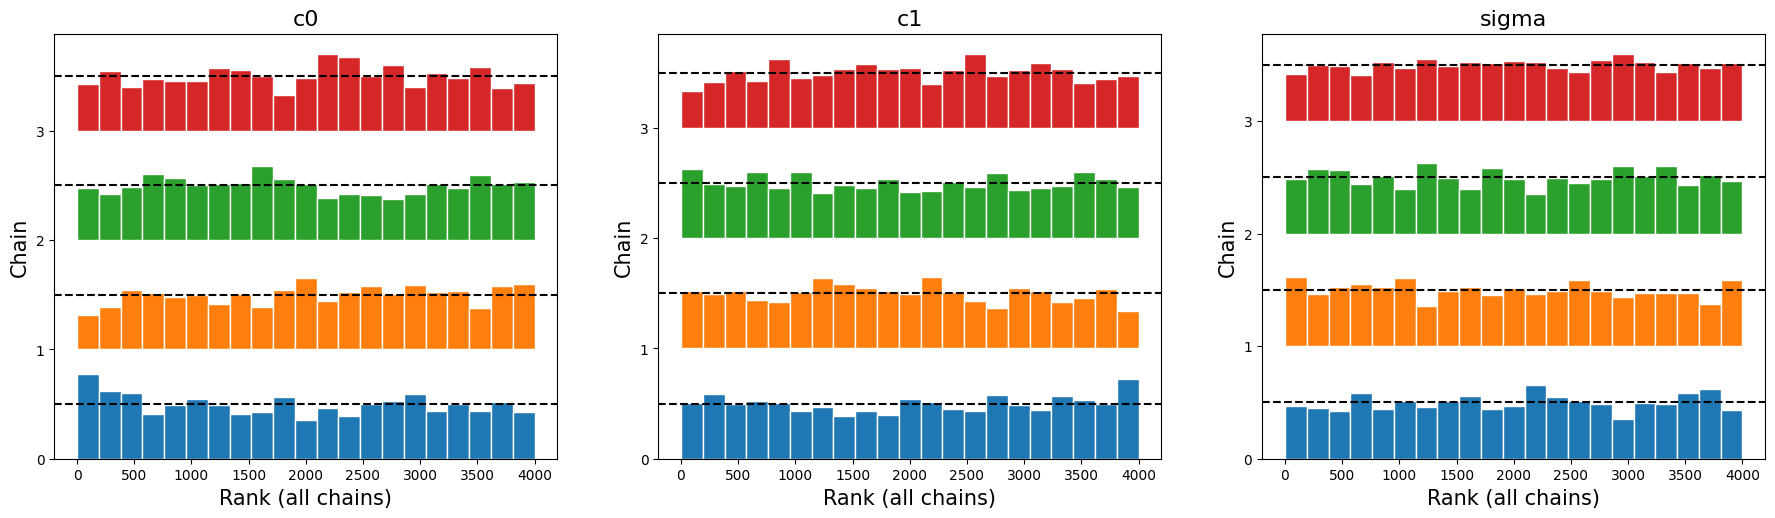

In [86]:
az.plot_rank(inference, var_names=['c0', 'c1', 'sigma']);

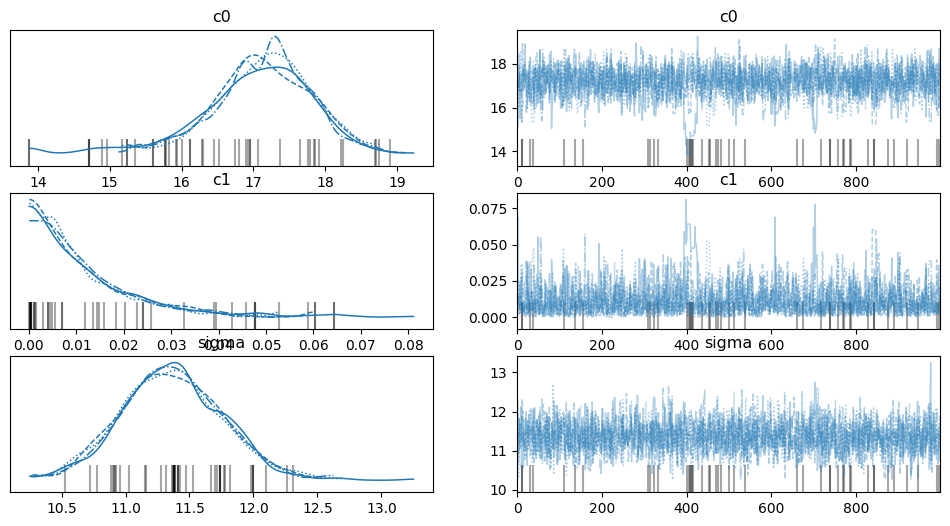

In [87]:
az.plot_trace(inference, var_names=['c0', 'c1', 'sigma']);

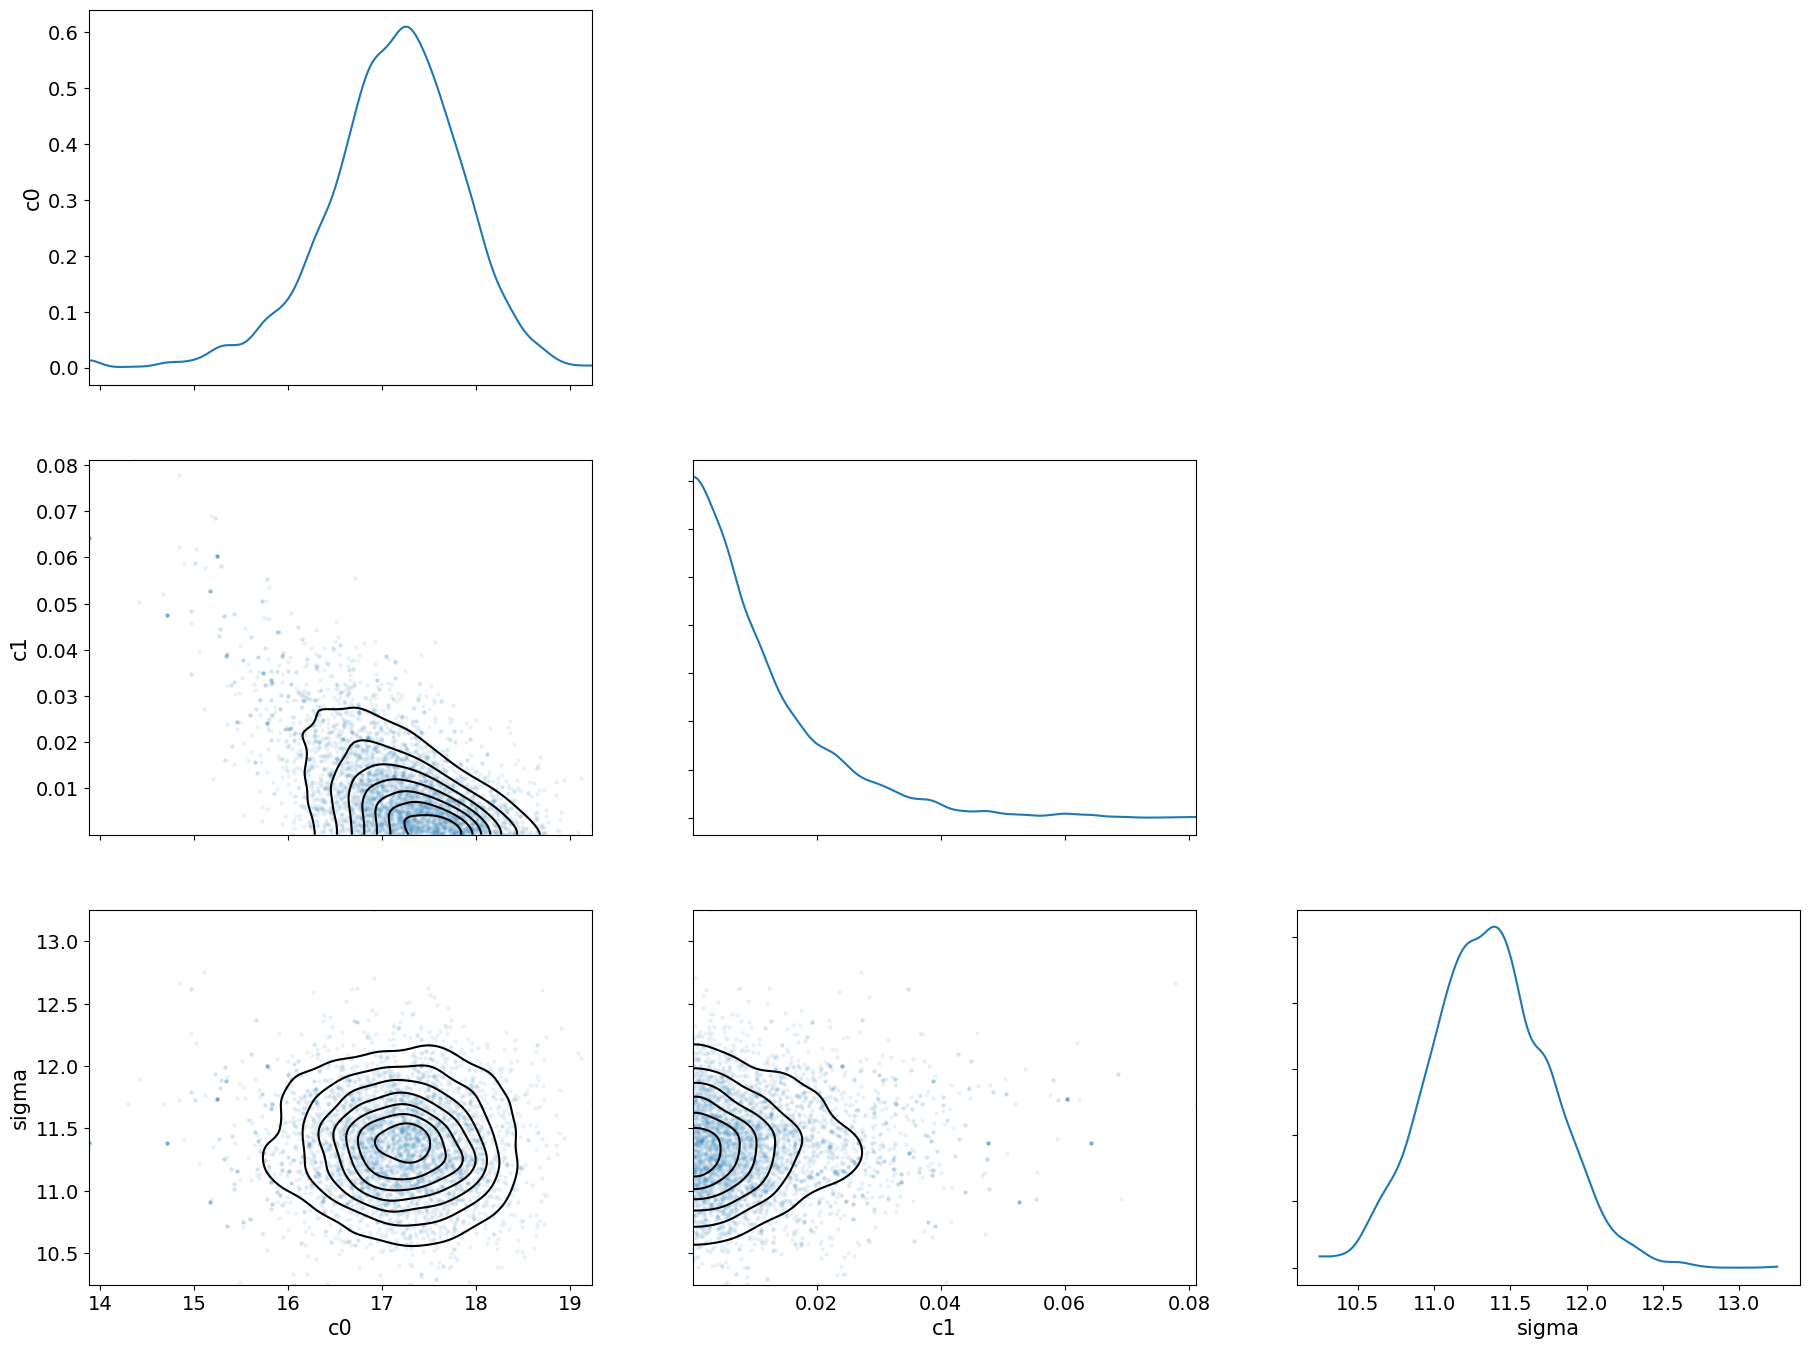

In [88]:
ax = az.plot_pair(
    inference,
    var_names=['c0', 'c1', 'sigma'],
    marginals=True,
    kind=["scatter", "kde"],
    scatter_kwargs={"color": "C0", "alpha": 0.1},
    marginal_kwargs={"kind": "kde", "color": "C0"},
    kde_kwargs={"contour_kwargs": {"colors": "k", 'alpha': 1}});

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


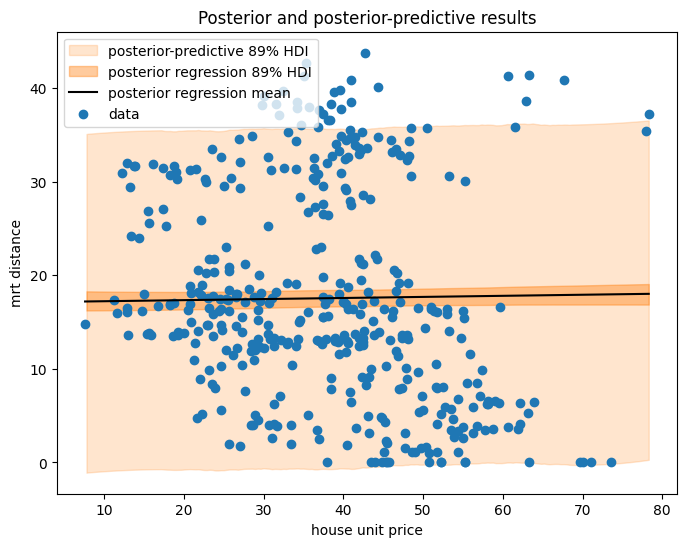

In [89]:
posterior_samples = inference.posterior.stack(
    sample=('chain', 'draw')).transpose('sample', ...)

# Compute posterior mu samples
plot_x = np.linspace(unit_price.min(), unit_price.max(), 200)
posterior_mu = (
    posterior_samples.c0.values.reshape(1, -1) +
    plot_x.reshape(-1, 1) * posterior_samples.c1.values.reshape(1, -1))

# Generate posterior-predictive y samples
posterior_y = sts.norm.rvs(
    loc = posterior_mu,
    scale=posterior_samples.sigma.values.reshape(1, -1),
    size=posterior_mu.shape)

# Plot posterior density intervals
plt.figure(figsize=(8, 6))
plt.title('Posterior and posterior-predictive results')
plt.xlabel('house unit price')
plt.ylabel('mrt distance')
ax = az.plot_hdi(plot_x, posterior_y.transpose(), hdi_prob=0.89, color='C1', fill_kwargs={'alpha': 0.2, 'label': 'posterior-predictive 89% HDI'})
az.plot_hdi(plot_x, posterior_mu.transpose(), ax=ax, hdi_prob=0.89, color='C1', fill_kwargs={'alpha': 0.4, 'label': 'posterior regression 89% HDI'})
plt.plot(plot_x, posterior_mu.mean(axis=1), color='black', label='posterior regression mean')
plt.scatter(unit_price, mrt_distance, color='C0', label='data')
plt.legend()
plt.show()